In [1]:
pip install tfimm

  Obtaining dependency information for tfimm from https://files.pythonhosted.org/packages/2b/58/da31a94293d086b353555d36d00eba9cb8c92fa85f161f2a27db9a9488cd/tfimm-0.2.14-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.9/225.9 kB 11.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# *Importing Libraries* 

In [1]:
import os
import cv2
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adamax
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, concatenate, Dense, BatchNormalization, Flatten, MaxPooling2D, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, matthews_corrcoef

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# *Preprocessing*

In [2]:
dataset_path = '/kaggle/input/nasal-bone-fracture-dataset/Dataset'

paths = []
labels = []

for category in ['normal', 'fracture']:
    category_path = os.path.join(dataset_path, category)

    for folder_name in os.listdir(category_path):
        folder_path = os.path.join(category_path, folder_name)

        if os.path.isdir(folder_path):
            for image_name in ['R', 'L']:
                image_path = os.path.join(folder_path, f'{image_name}.jpg')

                if os.path.exists(image_path):
                    paths.append(image_path)
                    labels.append(category)

                    
df = pd.DataFrame({'image_path': paths, 'label': labels})
df.head()

,image_path,label
0,/kaggle/input/nasal-bone-fracture-dataset/Data...,normal
1,/kaggle/input/nasal-bone-fracture-dataset/Data...,normal
2,/kaggle/input/nasal-bone-fracture-dataset/Data...,normal
3,/kaggle/input/nasal-bone-fracture-dataset/Data...,normal
4,/kaggle/input/nasal-bone-fracture-dataset/Data...,normal


In [3]:
df.shape

(2968, 2)

In [4]:
def read_images_from_df(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = row['image_path']
        if row['label'] == "normal":
            label = 0
        else: label = 1
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

images, labels = read_images_from_df(df)

## *Image Preprocessing*

In [5]:
def gaussian_noise(image):
    mean=0
    std=5
    noise = np.random.normal(mean, std, image.shape)
    
    noisy_image = image + noise
    
    noisy_image = np.clip(noisy_image, 0, 255)
    noisy_image = noisy_image.astype(np.uint8)
    
    return noisy_image

In [6]:
def sharpen_image(image, kernel_size=(3, 3), strength=0.2):
    kernel = np.array([[0, -1, 0],
                       [-1, 4, -1],
                       [0, -1, 0]])

    sharpened = cv2.filter2D(image, -1, kernel)

    sharpened = cv2.addWeighted(image, 1 + strength, sharpened, -strength, 0)

    return sharpened

In [7]:
def preprocessing(image):
    w = image.shape[1]

    img = image[int(0.2 * w) : int(0.8 * w), int(0.2 * w) : int(0.8 * w)]

    img = cv2.resize(img, (224,224), interpolation=cv2.INTER_AREA)

    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))

    cl1 = clahe.apply(gray_image)

    sharp1 = sharpen_image(cl1)

    sharp1 = 1 - sharp1

    sharp2 = sharpen_image(sharp1)

    sharp2 = 1 - sharp2

    rgb = cv2.cvtColor(sharp2, cv2.COLOR_GRAY2RGB)

    noise = gaussian_noise(rgb)

    return noise

In [8]:
images_temp = copy.deepcopy(images)

for i in range (len(images)):
    images[i] = preprocessing(images[i])

### Show sample

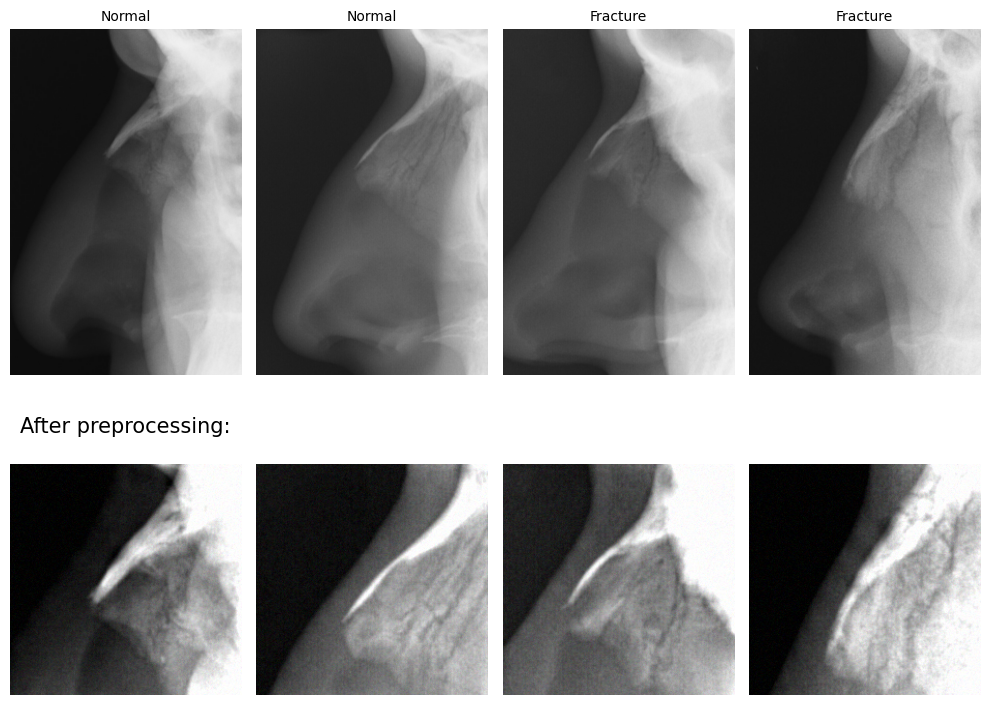

In [9]:
def show_smp(images, labels, preprocessed_images):
    fig, axes = plt.subplots(2, 4, figsize=(10, 8))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    axes[1, 0].set_title('After preprocessing:\n', fontsize=15)
    
    for i in range(4):
        idx = 2 * i + 1474
        ax = axes[0, i]
        ax.imshow(images[idx])
        if labels[idx] == 0:
            label = 'Normal'
        else:
            label = 'Fracture'
        ax.set_title(label, fontsize=10)
        ax.axis('off')

        ax = axes[1, i]
        ax.imshow(preprocessed_images[idx])
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    

show_smp(images_temp, labels, images)

## *Split data on train val test*

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(np.asarray(images), np.asarray(labels), test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [11]:
print("shape of X_train is: {} ".format(X_train.shape))
print("shape of X_val is: {}".format(X_val.shape))
print("shape of X_test is: {}".format(X_test.shape))
print()
print("shape of y_train is: {} ".format(y_train.shape))
print("shape of y_val is: {}".format(y_val.shape))
print("shape of y_test is: {}".format(y_test.shape))

shape of X_train is: (2077, 224, 224, 3) 
shape of X_val is: (445, 224, 224, 3)
shape of X_test is: (446, 224, 224, 3)

shape of y_train is: (2077,) 
shape of y_val is: (445,)
shape of y_test is: (446,)


## *Data Augmentation*

In [12]:
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(rescale=1./255) 

test_datagen = ImageDataGenerator(rescale=1./255) 


train_generator = train_datagen.flow(
    np.array(X_train), 
    y_train, 
    batch_size=batch_size,
    shuffle=True,
)

validation_generator = validation_datagen.flow(
    np.array(X_val),
    y_val,
    batch_size=batch_size,
    shuffle=False,  
)

test_generator = test_datagen.flow(
    np.array(X_test),
    y_test,
    batch_size=batch_size,
    shuffle=False,  
)

In [13]:
classes = np.unique(labels)
classes

array([0, 1])

In [14]:
img, lable = train_generator.next()
img.shape

(16, 224, 224, 3)

### Show sample:

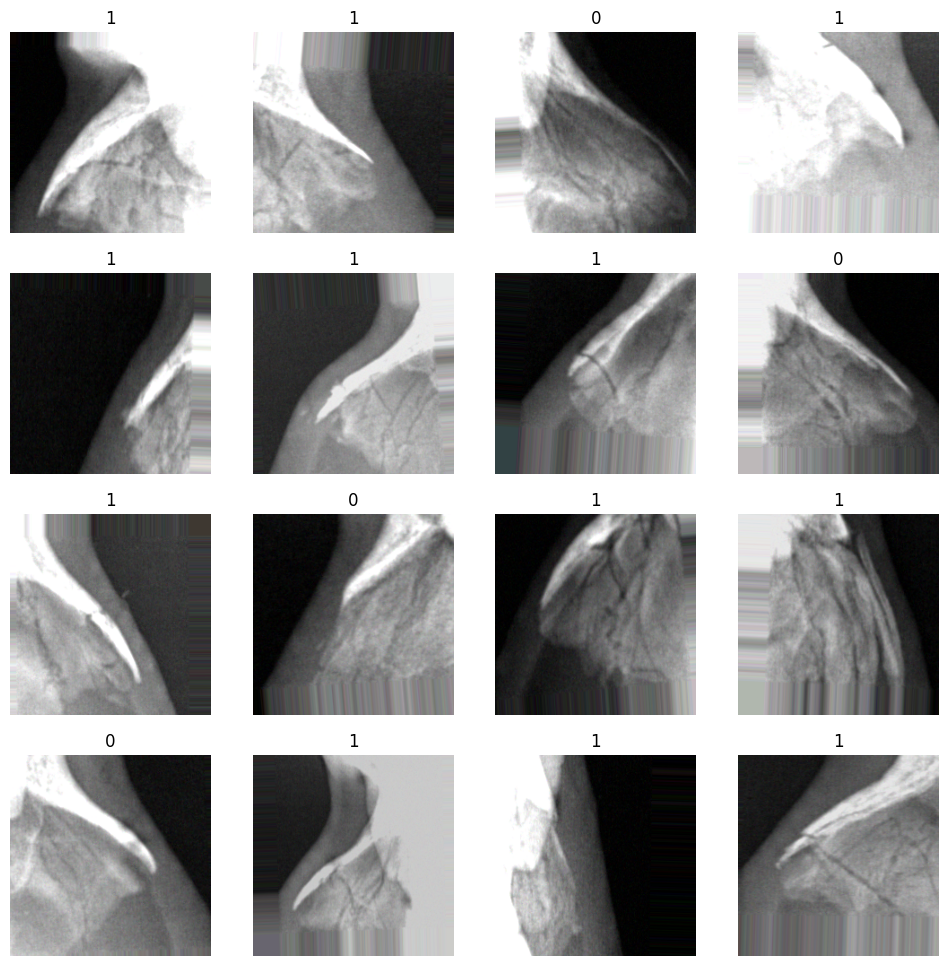

In [15]:
def show_sample(img, lable):
    plt.figure(figsize= (12, 12))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img[i])
        plt.title(lable[i])
        plt.axis('off')
    plt.show()
    
show_sample(img, lable)

In [16]:
def draw_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, axis = plt.subplots(1, 2, figsize=(15,6))
    axis[0].set_title('Training & validation accuracy', fontsize = 15, fontweight = 'bold')
    axis[0].plot(acc, label='training accuracy', color='navy')
    axis[0].plot(val_acc, label='validation accuracy', color='deeppink')
    axis[0].legend()
    axis[1].set_title('Training & validation loss', fontsize = 15, fontweight = 'bold')
    axis[1].plot(loss, label='training loss', color='navy')
    axis[1].plot(val_loss, label='validation loss', color='deeppink')
    axis[1].legend()
    
    print("Maximum Accuracy of Training set: {:.3f}\nMinimum Loss of Trainig set: {:.8f}\n".format(np.max(acc)*100, np.min(loss)))
    print("Maximum Accuracy of Validation set: {:.3f}\nMinimum Loss of Validation set: {:.8f}\n".format(np.max(val_acc)*100, np.min(val_loss))) 

In [17]:
def roc_auc_score_(y_test, y_pred):
    auc_ = roc_auc_score(y_test, y_pred)
    print("AUC:", auc_)    
    print()
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='khaki', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
def confusion_matrix_(y_test, y_pred, name):
    cm = confusion_matrix(y_test, y_pred)
    cmap = sns.color_palette(["#FFFFFF", "#00004D"]) 

    class_labels = ['normal', 'fracture']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, linewidths=1.5, 
                linecolor='black', xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted label", fontsize = 12, fontweight = 'bold')
    plt.ylabel("True label", fontsize = 12, fontweight = 'bold')
    plt.title(name, fontsize = 15, fontweight = 'bold')
    plt.show()

In [19]:
def lr_schedule(epoch):
    initial_learning_rate = LR
    decay = 0.92
    lr = initial_learning_rate * decay**(1.25 * epoch)
    if lr > 1e-4:
        return lr
    else:
        return 1e-4
    
lr_scheduler = LearningRateScheduler(lr_schedule)

In [20]:
EPOCHS = 50
IMG_SHAPE = (224, 224, 3)
LR = 5e-4
OPTIMIZER = tf.keras.optimizers.legacy.Adamax(LR)
LOSS = SparseCategoricalCrossentropy()
METRICS = ['accuracy']

# *Model Structure*

In [21]:
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

base_model.trainable = True
print("Number of layers in the base_model: ", len(base_model.layers))

29084464/29084464 [==============================] - 0s 0us/step
Number of layers in the base_model:  427


In [22]:
for layer in base_model.layers[:250]:
    layer.trainable = False

In [23]:
Model = Sequential([
    base_model,
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"),
    Flatten(),
    Dropout(0.5),
    BatchNormalization(),
    Dense(512, 'relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(64, 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(len(classes), "sigmoid")
])

Model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [24]:
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 1024)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dropout (Dropout)           (None, 9216)              0         
                                                                 
 batch_normalization (Batch  (None, 9216)              36864     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               4

In [40]:
len(Model.trainable_variables)

140

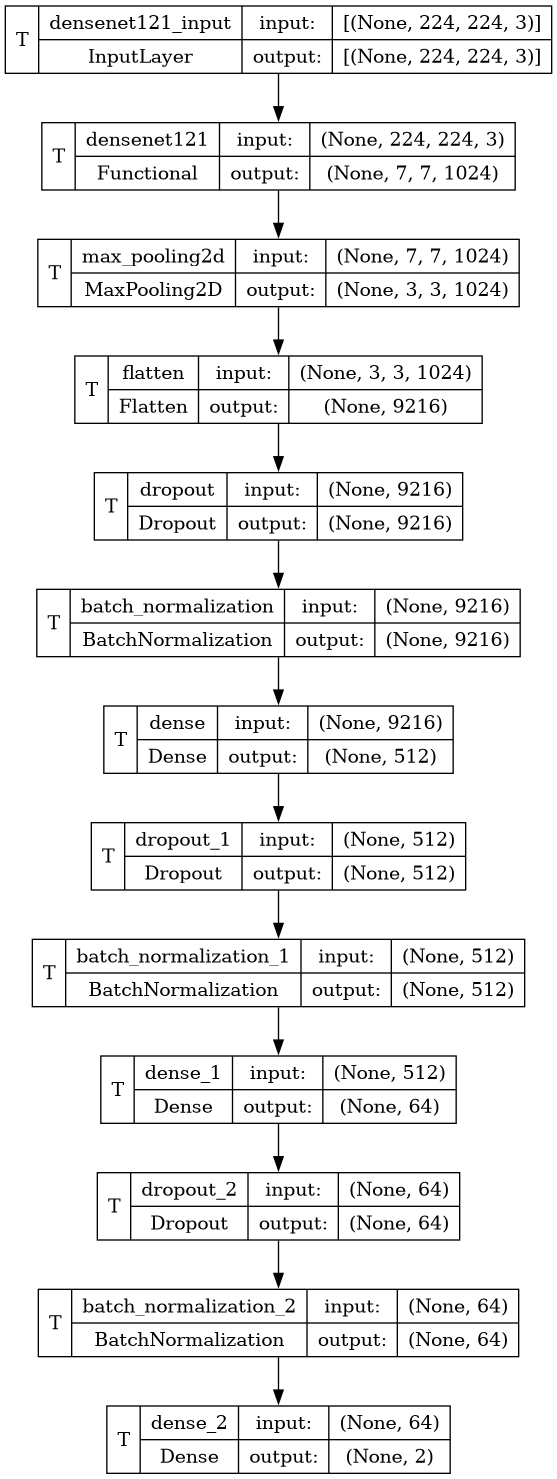

In [25]:
plot_model(Model, show_shapes = True, show_trainable = True)

In [26]:
hist = Model.fit(train_generator, validation_data = validation_generator, epochs = EPOCHS, callbacks=[lr_scheduler])

Epoch 1/50
130/130 [==============================] - 43s 232ms/step - loss: 2.0869 - accuracy: 0.5286 - val_loss: 1.7466 - val_accuracy: 0.6090 - lr: 5.0000e-04
Epoch 2/50
130/130 [==============================] - 27s 204ms/step - loss: 1.9035 - accuracy: 0.5811 - val_loss: 1.6334 - val_accuracy: 0.6854 - lr: 4.5051e-04
Epoch 3/50
130/130 [==============================] - 27s 205ms/step - loss: 1.8054 - accuracy: 0.6182 - val_loss: 1.4942 - val_accuracy: 0.7326 - lr: 4.0592e-04
Epoch 4/50
130/130 [==============================] - 26s 202ms/step - loss: 1.7441 - accuracy: 0.6428 - val_loss: 1.4387 - val_accuracy: 0.7640 - lr: 3.6574e-04
Epoch 5/50
130/130 [==============================] - 27s 204ms/step - loss: 1.6161 - accuracy: 0.6914 - val_loss: 1.4162 - val_accuracy: 0.7685 - lr: 3.2954e-04
Epoch 6/50
130/130 [==============================] - 27s 205ms/step - loss: 1.5837 - accuracy: 0.6923 - val_loss: 1.3865 - val_accuracy: 0.7798 - lr: 2.9692e-04
Epoch 7/50
130/130 [========

Maximum Accuracy of Training set: 92.345
Minimum Loss of Trainig set: 0.77338558

Maximum Accuracy of Validation set: 83.820
Minimum Loss of Validation set: 1.05522037



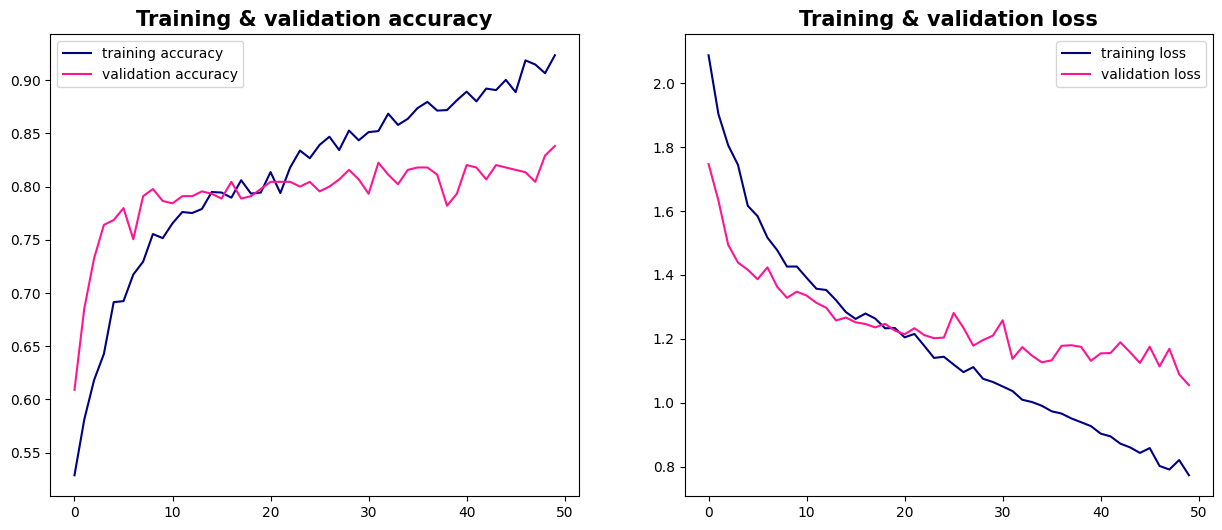

In [27]:
draw_plot(hist)

### *Evaluation*

In [28]:
loss, accuracy = Model.evaluate(test_generator)
print('Test accuracy :', accuracy * 100)

28/28 [==============================] - 3s 92ms/step - loss: 1.0085 - accuracy: 0.8094
Test accuracy : 80.94170689582825


In [29]:
predictions = Model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

28/28 [==============================] - 3s 35ms/step


### *Classification report*

In [30]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f0_5_score = fbeta_score(y_test, y_pred, beta=0.5)
f1_score = fbeta_score(y_test, y_pred, beta=1)
f2_score = fbeta_score(y_test, y_pred, beta=2)
mcc_score = matthews_corrcoef(y_test, y_pred)

output = (
    f"{'Metric':<15}{'Score':>10}\n"
    f"{'-'*25}\n"
    f"{'Precision':<15}{precision:>10.6f}\n"
    f"{'Recall':<15}{recall:>10.6f}\n"
    f"{'F0.5 Score':<15}{f0_5_score:>10.6f}\n"
    f"{'F1 Score':<15}{f1_score:>10.6f}\n"
    f"{'F2 Score':<15}{f2_score:>10.6f}\n"
    f"{'MCC Score':<15}{mcc_score:>10.6f}"
)

print(output)

Metric              Score
-------------------------
Precision        0.809715
Recall           0.809417
F0.5 Score       0.810296
F1 Score         0.800000
F2 Score         0.789963
MCC Score        0.618649


In [31]:
report = classification_report(y_test, y_pred, target_names=['normal', 'fracture'])
print(report)

              precision    recall  f1-score   support

      normal       0.80      0.83      0.82       229
    fracture       0.82      0.78      0.80       217

    accuracy                           0.81       446
   macro avg       0.81      0.81      0.81       446
weighted avg       0.81      0.81      0.81       446



### *Confusion matrix*

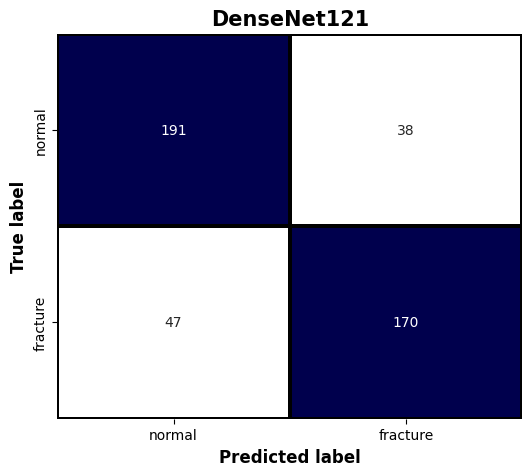

In [34]:
confusion_matrix_(y_test, y_pred, name="DenseNet121")

### *ROC & AUC*

AUC: 0.8087356368100135



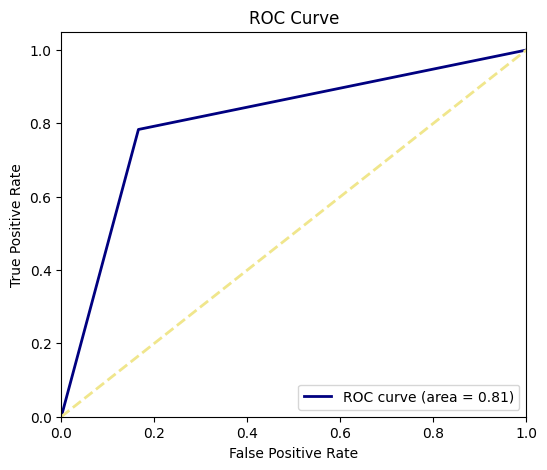

In [33]:
roc_auc_score_(y_test, y_pred)